In [2]:
from collections import Counter
import jieba
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os

from wordcloud import WordCloud
import re
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer 
from matplotlib.font_manager import FontProperties
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
def read_text(file):
	with open(file, 'r', encoding = 'utf-8') as myfile:
		return myfile.read().replace('\n', '')

def read_text_folder(folder = r'./Text_Folder/', return_names=False):
	file_names = os.listdir(folder)
	text_list = [read_text(folder + f) for f in file_names]
	if return_names:
		return (text_list, file_names)
	else:
		return text_list


def read_word_dict(file):
	with open(file, 'r',  encoding = 'utf-8') as myfile:
		word_list = myfile.read().split('\n')
	
	for i in word_list:
		jieba.add_word(i)

def read_words(file, sep='\n'):
	with open(file, 'r',  encoding = 'utf-8') as myfile:
		word_list = myfile.read().split(sep)
		return word_list

def tokenize_text(text, cut_all=False):
	return [i for i in jieba.cut(text, cut_all=cut_all)]

def count_words(seg_list, stopwords=[], puncs='', stop_pattern='[0-9]+'):
	unnecessary_words = stopwords + list(puncs)
	count_dict = {}
	for w in seg_list:
		if (w not in unnecessary_words) and (re.match(stop_pattern, w) is None):
			if w in count_dict.keys():
				count_dict[w] = count_dict[w] + 1
			else:
				count_dict[w] = 1
	return count_dict

def count_words_in_documents(doc_list, doc_names, stopwords=[], puncs='', stop_pattern='[0-9]+'):
	documents_words_count = {}
	for i in range(len(doc_list)):
		tokenized_doc = tokenize_text(doc_list[i])
		documents_words_count[doc_names[i]] = count_words(tokenized_doc, stopwords, puncs, stop_pattern)
	return documents_words_count



def plot_wordcloud(word_dict, 
				   ax = None,
				   font_path = r'example/font/path/LoremIpsum.ttc',
				   background_color = "white",
				   width = 1000,
				   height = 860,
				   margin = 2):
	wordcloud = WordCloud(font_path=font_path, background_color=background_color, width=width, height=height, margin=margin)
	wordcloud.fit_words(word_dict)
	if ax is None:
		plt.imshow(wordcloud)
	else:
		ax.imshow(wordcloud)


def plot_tf_bar(word_dict,
				ax = None,
				font_path = r'example/font/path/LoremIpsum.ttc',
				bin = 20,
				figsize = (10, 6),
				title = None,
				xticks_fontsize = 10,
				title_fontsize = 20,
				**kwargs):

	sorted_word_dict = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
	index = range(bin)
	label = [i[0] for i in sorted_word_dict[:bin]]
	value = [i[1] for i in sorted_word_dict[:bin]]
	font = FontProperties(fname=font_path)
	if ax is None:
		plt.figure(figsize=figsize)
		plt.bar(index, value, **kwargs)
		plt.xticks(index, label, fontsize=xticks_fontsize, fontproperties=font)
		if not title is None:
			plt.title(title, fontsize=title_fontsize)
	else:
		ax.bar(index, value, **kwargs)
		ax.set_xticks(index)
		ax.set_xticklabels(label, fontsize=xticks_fontsize, fontproperties=font)
		if not title is None:
			ax.set_title(title, fontsize=title_fontsize, fontproperties=font)

def get_sentences(text, sep=' '):
	sentences = text.split(sep)
	return sentences

def tokenize_sentences(sentences):
	tokenized_sentences = {}
	for i in sentences:
		tokenized_sentences[i] = tokenize_text(i)
	return tokenized_sentences


def count_words_in_sentences(tokenized_sentence, stopwords=[], puncs='', stop_pattern='[0-9]+'):
	sentences_words_count = {}
	for key, value in tokenized_sentence.items():
		sentences_words_count[key] = count_words(value, stopwords=stopwords, puncs=puncs,  stop_pattern=stop_pattern)
	return sentences_words_count

def create_word_frequency_matrix(documents_words_count, text_index=None):
	total_words = [word for count in documents_words_count.values() for word in count] 
	unique_word_set = set(total_words)
	for doc, count in documents_words_count.items():
		for zero_word in unique_word_set - set(count.keys()):
			documents_words_count[doc][zero_word] = 0
	
	word_frequency = pd.DataFrame(documents_words_count).T
	if text_index is None:
		word_frequency.index = range(len(word_frequency.index))
	else:
		word_frequency.index = text_index
	return word_frequency

def evaluate_tfidf(word_frequency, drop_freq=0):
	transformer = TfidfTransformer()
	tfidf = transformer.fit_transform(word_frequency.values)  
	df_tfidf = pd.DataFrame(tfidf.toarray(), columns = word_frequency.columns.tolist())
	return df_tfidf

def plot_tfidf_wordcloud(df_tfidf, text_index=0, ax=None, font_path=r'example/font/path/LoremIpsum.ttc', background_color="white", width=1000, height=860, margin=2):
	tfidf_dict = df_tfidf.to_dict(orient='records')
	if ax is None:
		plot_wordcloud(tfidf_dict[text_index], font_path=font_path, background_color=background_color, width=width, height=height, margin=margin)
	else:
		plot_wordcloud(tfidf_dict[text_index], ax=ax, font_path=font_path, background_color=background_color, width=width, height=height, margin=margin)

def plot_tfidf_bar(df_tfidf,
				   text_index=0,
				   ax=None,
				   font_path=r'example/font/path/LoremIpsum.ttc',
				   bin=20,
				   figsize=(10, 6),
				   xticks_fontsize = 10,
				   title_fontsize = 26,
				   **kwargs):
	tfidf_dict = df_tfidf.to_dict(orient='records')
	plot_tf_bar(tfidf_dict[text_index], ax=ax, font_path=font_path, bin=bin, figsize=figsize, xticks_fontsize = 10, title_fontsize = 20, **kwargs)


def set_puncs(add_puncs=''):
	full_space_puncs = '！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｢｣､、〃》「」『』【】〔〕〝〞〰–—‘’‛“”„‟…‧﹏.。'
	half_space_puncs = """!?." #$%&' ()*+,-/:;<=>[\]@^_{|}~"""
	return full_space_puncs + half_space_puncs +  add_puncs

def PCA_tfidf(df_tfidf, n_components=2, index=None):
	pca = PCA(n_components=n_components)
	pca_df_tfidf = pca.fit_transform(df_tfidf)
	pca_df_tfidf = pd.DataFrame(pca_df_tfidf)
	if index is None:
		pca_df_tfidf.index = df_tfidf.index
	else:
		pca_df_tfidf.index = index
	return pca_df_tfidf



def KMeans_tfidf(pca_df_tfidf, KMeans_object, only_label=True):
	kmeans = KMeans_object
	clustered = kmeans.fit(pca_df_tfidf.values)
	labels = pd.Series(clustered.labels_, name='Label', index=pca_df_tfidf.index)
	if only_label == True:
		return labels
	else:
		tfidf_clustered = pd.concat([pca_df_tfidf, labels], axis=1)
		return tfidf_clustered

def plot_kmeans_scatter(tfidf_clustered,
						ax = None, 
						kmeans_label = None,
						figsize = (8,8),
						label_color_map = None,
						alpha = None,
						title = None,
						title_fontsize = 36,
						font_path = r'example/font/path/LoremIpsum.ttc',
						annotate = True,
						annotate_fontsize = 12):

	font = FontProperties(fname=font_path)
	tag = tfidf_clustered.index

	if kmeans_label is None:
		label = tfidf_clustered['Label'].values
	else:
		label = kmeans_label

	if label_color_map is None:
		label_color = label
	else:
		label_color = [label_color_map[i] for i in label]

	if ax is None:
		plt.figure(figsize = figsize)
		plt.scatter(tfidf_clustered.iloc[:,0], tfidf_clustered.iloc[:,1], c=label_color, alpha=alpha)
		if not title is None:
			params = {'axes.titlesize':title_fontsize}
			plt.rcParams.update(params)
			plt.title(title, fontproperties=font)
		if annotate == True:
			for i in range(len(tag)):
				plt.annotate(tag[i], xy=(tfidf_clustered.iloc[i,0], tfidf_clustered.iloc[i,1]), fontsize=annotate_fontsize, fontproperties=font)
		plt.show()
	else:
		ax.scatter(tfidf_clustered.iloc[:,0], tfidf_clustered.iloc[:,1], c=label_color, alpha=alpha)
		if not title is None:
			params = {'axes.titlesize':title_fontsize}
			plt.rcParams.update(params)
			ax.set_title(title, fontproperties=font)
		if annotate == True:
			for i in range(len(tag)):
				ax.annotate(tag[i], xy=(tfidf_clustered.iloc[i,0], tfidf_clustered.iloc[i,1]), fontsize=annotate_fontsize, fontproperties=font)

In [4]:
text_list = read_text_folder("dataset2/")
print("document number:", len(text_list))

document number: 1


#### 製作詞頻矩陣
下面以 Python 實現製作詞頻矩陣的步驟，並附上對應的fintextmin函式

In [5]:
## [原生 python 寫法]
doc_names = range(len(text_list))
dwc = {key: [word for word in jieba.cut(text, cut_all=False)] for (key, text) in zip(doc_names, text_list)}


## [使用 fintextmin 模組]
# stopwords = [] 
# dwc = count_words_in_documents(doc_list = text_list,
#                               doc_names = range(len(text_list)),
#                                stopwords = stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jasonsu\AppData\Local\Temp\jieba.cache
Loading model cost 1.178 seconds.
Prefix dict has been built succesfully.


In [6]:
## [原生 python 寫法] 
doc_word_frequency = {key: {i:Counter(doc)[i] for i in Counter(doc)} for key, doc in dwc.items()}
list(doc_word_frequency[0].items())[0:10] # 顯示第一篇文章的部份詞彙與對應詞頻

## [使用 fintextmin 寫法]
# doc_word_frequency = create_word_frequency_matrix(dwc)

[('主席', 1),
 (' ', 38),
 ('各位', 2),
 ('貴賓', 1),
 ('、', 1),
 ('教育部', 1),
 ('長', 1),
 ('老師', 1),
 ('與', 1),
 ('和', 1)]

In [7]:
## [原生 python 寫法] 
dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
wfm = pd.concat(dwf_list, axis= 1)
wfm = np.transpose(wfm).fillna(0)
wfm.index = doc_word_frequency.keys()

puncs = set_puncs() # 因為一開始沒有清除標點符號,這邊回過頭來將它們自矩陣移除
wfm = wfm[list(set(wfm) - set(puncs))]
wfm # 詞頻矩陣完成

## [使用 fintextmin 寫法]
# wfm = create_word_frequency_matrix(dwc)

,們,慢放,教育部,一直,未來,你,位良師,大家,令人,扶搖直,...,來,可以,體魄,是,被,達布德罕,遍布,隨他,貴賓,你給
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,4,1,1,1,1,1,1


#### 製作TF-IDF矩陣
可以將完成後的tf-idf矩陣與上面的詞頻矩陣比較一下係數

In [8]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer

## [原生 python 寫法] 
transformer = TfidfTransformer()
tfidf_gen = transformer.fit_transform(wfm) # 產生一個 tfidf 矩陣的 generator
df_tfidf = pd.DataFrame(tfidf_gen.toarray(), columns=wfm.columns)
df_tfidf

## [使用 fintextmin 寫法]
# df_tfidf = evaluate_tfidf(wfm)

,們,慢放,教育部,一直,未來,你,位良師,大家,令人,扶搖直,...,來,可以,體魄,是,被,達布德罕,遍布,隨他,貴賓,你給
0,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268,...,0.037268,0.037268,0.037268,0.149071,0.037268,0.037268,0.037268,0.037268,0.037268,0.037268


#### 視覺化TFIDF和原本詞頻矩陣的差異
這邊我們取第一篇文章來比較看看調整前後的詞彙係數

In [9]:
first_text = wfm.to_dict(orient='records')[0] # 將詞頻矩陣轉換成dictionary型別, 把第一篇文章抽出來
list(first_text.items())[0:10] # 檢視一下轉換結果

[('們', 1),
 ('慢放', 1),
 ('教育部', 1),
 ('一直', 1),
 ('未來', 1),
 ('你', 1),
 ('位良師', 1),
 ('大家', 1),
 ('令人', 1),
 ('扶搖直', 1)]

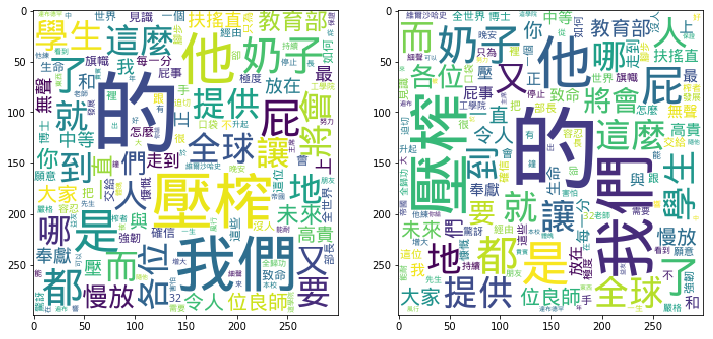

In [10]:
linux_font = r'wqy-microhei.ttc'

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plot_wordcloud(first_text, ax=ax1, font_path=linux_font, height=300, width=300)

ax2 = plt.subplot(122)
plot_tfidf_wordcloud(df_tfidf, text_index=0, ax=ax2, font_path=linux_font, height=300, width=300)

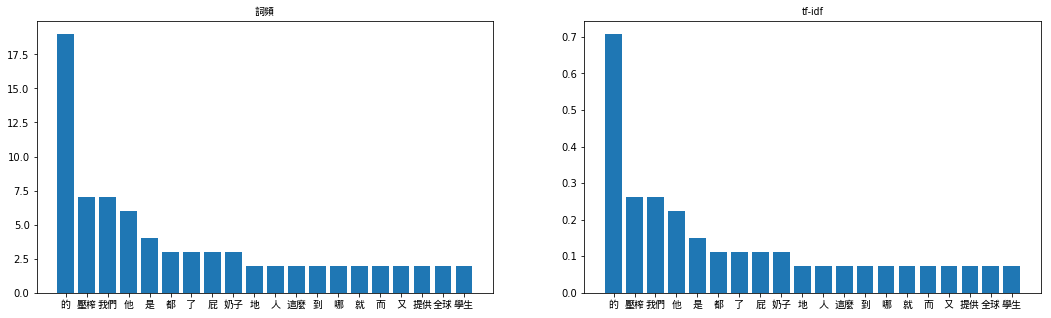

In [11]:
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(121)
plot_tf_bar(first_text, ax=ax1, font_path=linux_font, title="詞頻")

ax2 = plt.subplot(122)
plot_tfidf_bar(df_tfidf, text_index=0, ax=ax2, font_path=linux_font, title="tf-idf")